In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.layers import Input
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, concatenate, Dropout, Conv1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from keras.models import Model

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/aspect_sentiment_dataset_final.xlsx')
df = df.drop(columns=['Unnamed: 0'], axis=1)
df[0:10]

,Unnamed: 0.1,review,annotated_review,aspect,aspect_sentiment
0,0,I bought mine 4/17 with 98K. Have been wantin...,I bought mine 4/17 with 98K. Have been wantin...,performance,negative
1,1,I bought mine 4/17 with 98K. Have been wantin...,I bought mine 4/17 with 98K. Have been wantin...,engine,negative
2,2,I bought mine 4/17 with 98K. Have been wantin...,I bought mine 4/17 with 98K. Have been wantin...,power,negative
3,3,I bought mine 4/17 with 98K. Have been wantin...,I bought mine 4/17 with 98K. Have been wantin...,mileage,negative
4,4,"Lots of problems with Ford these days, sensor...","Lots of problems with Ford these days, [senso...",sensors,neutral
5,5,Bought mine used 20k on it and have added a S...,Bought mine used 20k on it and have added a S...,performance,negative
6,6,Bought mine used 20k on it and have added a S...,Bought mine used 20k on it and have added a S...,comfort,neutral
7,7,I drive 50 miles each way to work and traded ...,I drive 50 miles each way to work and traded ...,performance,neutral
8,8,I drive 50 miles each way to work and traded ...,I drive 50 miles each way to work and traded ...,engine,negative
9,10,This car is just awesome. The 4.6L V8 makes ...,This car is just awesome. The 4.6L V8 makes ...,price,neutral


In [ ]:
# Preprocessing
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove punctuations
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['review'] = df['review'].apply(preprocess_text)
df['aspect'] = df['aspect'].apply(preprocess_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review'].values + df['aspect'].values)

X_review = tokenizer.texts_to_sequences(df['review'].values)
X_aspect = tokenizer.texts_to_sequences(df['aspect'].values)

# Padding
max_sequence_length = 100
X_review = pad_sequences(X_review, maxlen=max_sequence_length)
X_aspect = pad_sequences(X_aspect, maxlen=max_sequence_length)

# Label encoding
y = pd.get_dummies(df['aspect_sentiment']).values

In [ ]:
# Train-test split
X_train_review, X_test_review, X_train_aspect, X_test_aspect, y_train, y_test = train_test_split(
    X_review, X_aspect, y, test_size=0.3, random_state=42)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, LSTM, Reshape


embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

# Review input branch
review_input = Input(shape=(max_sequence_length,))
review_embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(review_input)
review_lstm = LSTM(32, return_sequences=True)(review_embedding)
review_reshaped = Reshape((-1, 32))(review_lstm)  # Reshape the output for Conv1D
review_conv = Conv1D(32, 3, activation='relu')(review_reshaped)
review_lstm = LSTM(64, return_sequences=True)(review_conv)
review_reshaped = Reshape((-1, 64))(review_lstm)  # Reshape the output for Conv1D
review_conv = Conv1D(64, 3, activation='relu')(review_reshaped)
review_pooling = GlobalMaxPooling1D()(review_conv)

# Aspect input branch
aspect_input = Input(shape=(max_sequence_length,))
aspect_embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(aspect_input)
aspect_lstm = LSTM(32, return_sequences=True)(aspect_embedding)
aspect_reshaped = Reshape((-1, 32))(aspect_lstm)  # Reshape the output for Conv1D
aspect_conv = Conv1D(32, 3, activation='relu')(aspect_reshaped)
aspect_lstm = LSTM(64, return_sequences=True)(aspect_conv)
aspect_reshaped = Reshape((-1, 64))(aspect_lstm)  # Reshape the output for Conv1D
aspect_conv = Conv1D(64, 3, activation='relu')(aspect_reshaped)
aspect_pooling = GlobalMaxPooling1D()(aspect_conv)

# Merge review and aspect branches
merged = concatenate([review_pooling, aspect_pooling])
dropout = Dropout(0.2)(merged)
dense = Dense(128, activation='relu')(dropout)
# dense = Dense(64, activation='relu')(dense) # 32, 64
# dropout = Dropout(0.2)(dense)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=[review_input, aspect_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             2330600   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 100)             2330600   ['input_2[0][0]']             
                                                                                              

In [ ]:
# Train the model
# Train the model
epochs = 30
batch_size = 32
checkpoint = ModelCheckpoint('cnn_lstm_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train_review, X_train_aspect], y_train, validation_data=([X_test_review, X_test_aspect], y_test),
                    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

Epoch 1/30
229/229 [==============================] - ETA: 0s - loss: 0.8398 - accuracy: 0.6245
Epoch 1: val_accuracy improved from -inf to 0.66561, saving model to cnn_lstm_model.hdf5
229/229 [==============================] - 83s 314ms/step - loss: 0.8398 - accuracy: 0.6245 - val_loss: 0.7582 - val_accuracy: 0.6656
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7175
Epoch 2: val_accuracy improved from 0.66561 to 0.67739, saving model to cnn_lstm_model.hdf5
229/229 [==============================] - 70s 305ms/step - loss: 0.6669 - accuracy: 0.7175 - val_loss: 0.7662 - val_accuracy: 0.6774
Epoch 3/30
229/229 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.7679
Epoch 3: val_accuracy improved from 0.67739 to 0.71274, saving model to cnn_lstm_model.hdf5
229/229 [==============================] - 69s 303ms/step - loss: 0.5826 - accuracy: 0.7679 - val_loss: 0.7992 - val_accuracy: 0.7127
Epoch 4/30
229/229 [==============================] - ETA: 0s - loss: 0.4983 - accuracy: 0.8131
Epoch 4: val_accuracy improved from 0.71274 to 0.72389, saving model to cnn_lstm_model.hdf5
229/229 [==============================] - 67s 291ms/step - loss: 0.4983 - accuracy: 0.8131 - val_loss: 0.9465 - val_accuracy: 0.7239
Epoch 5/30
229/229 [=========================

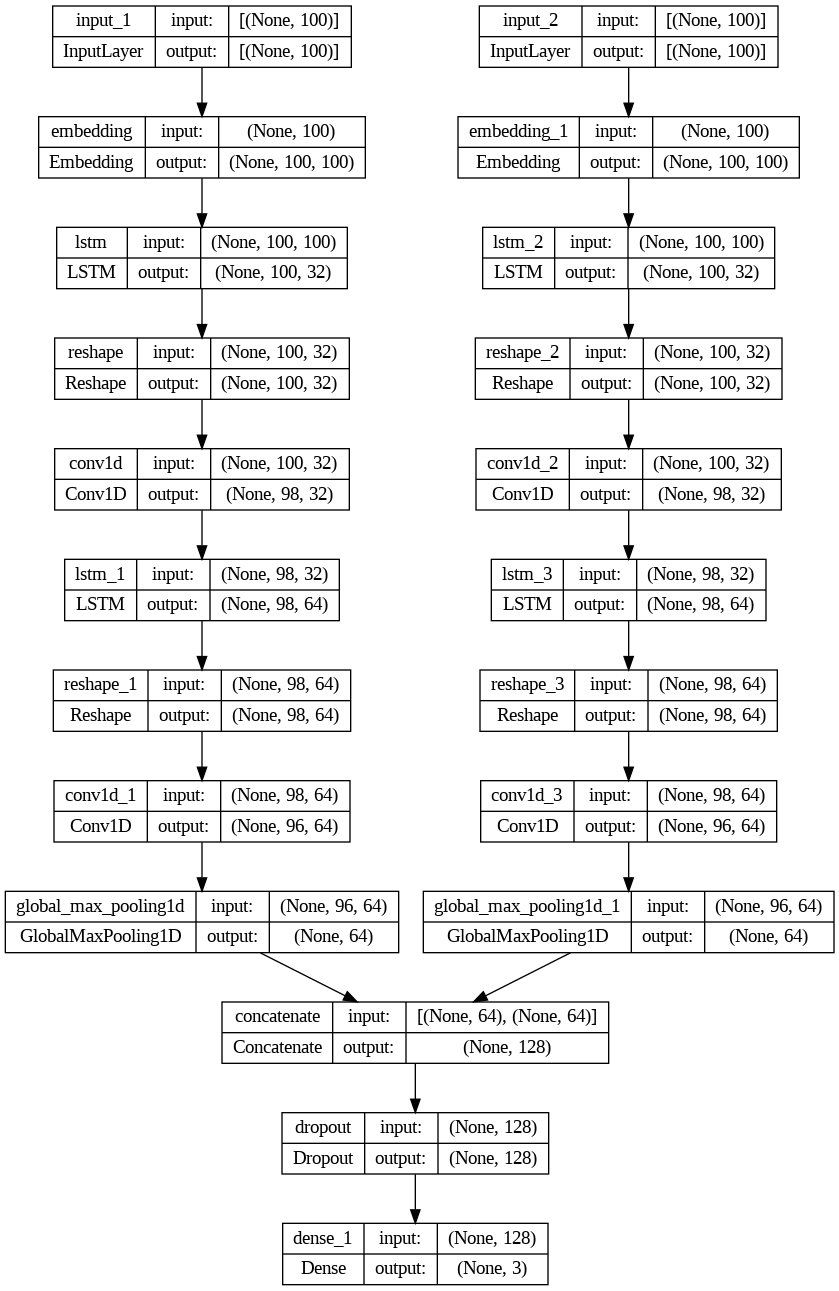

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Evaluate the model
y_pred = model.predict([X_test_review, X_test_aspect])
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

99/99 [==============================] - 7s 49ms/step
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       629
           1       0.74      0.60      0.66       787
           2       0.79      0.87      0.83      1724

    accuracy                           0.74      3140
   macro avg       0.71      0.68      0.69      3140
weighted avg       0.74      0.74      0.74      3140

[[ 362   65  202]
 [ 113  473  201]
 [ 129  101 1494]]
Accuracy: 74.17%


99/99 [==============================] - 5s 51ms/step


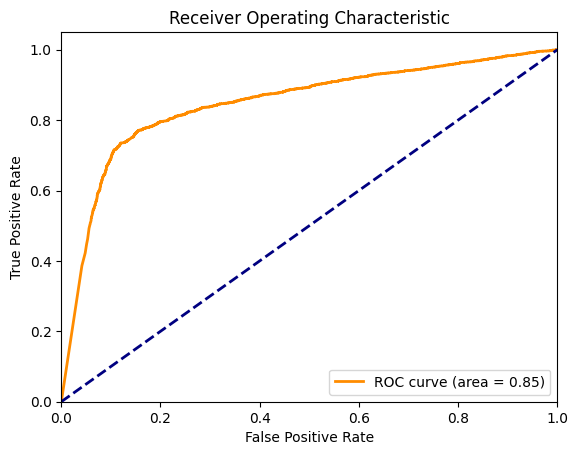

In [ ]:
# ROC curve
y_scores = model.predict([X_test_review, X_test_aspect])
fpr, tpr, _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

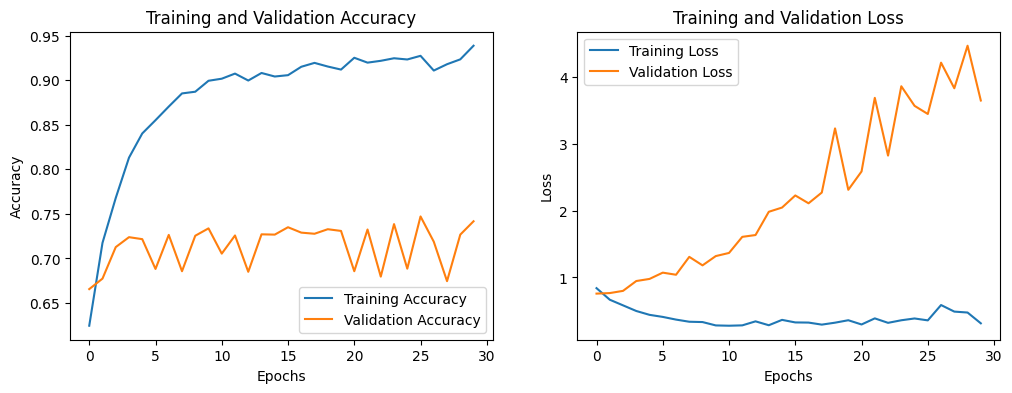

In [ ]:

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()